In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from xgboost import plot_importance, plot_tree

In [2]:
# lib configuration
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = (15,8)

Let's try one more time. Compare efectinvess of Tree boosting and ETS models on USD price pridiction 

In [3]:
DATA_PATH = "data/eurusd_hour.csv"

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
df.head()

,Date,Hour,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
0,2002-05-05,19:00,0.9168,0.9168,0.9168,0.9168,0.0,0.9178,0.9178,0.9178,0.9178,0.0
1,2002-05-06,20:00,0.9181,0.9181,0.9181,0.9181,0.0,0.9184,0.9184,0.9184,0.9184,0.0
2,2002-05-07,20:00,0.9152,0.9152,0.9152,0.9152,0.0,0.9155,0.9155,0.9155,0.9155,0.0
3,2002-05-08,20:00,0.9042,0.9042,0.9042,0.9042,0.0,0.9045,0.9045,0.9045,0.9045,0.0
4,2002-05-09,20:00,0.9092,0.9092,0.9092,0.9092,0.0,0.9095,0.9095,0.9095,0.9095,0.0


In [6]:
df['Date'] = pd.to_datetime(df['Date']) # convert to datetime object

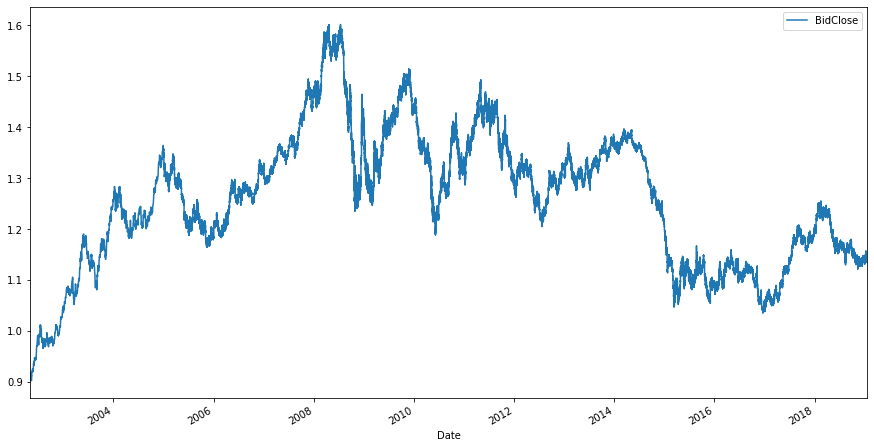

In [7]:
df.plot(x='Date', y='BidClose', figsize=(15,8))

In [124]:
split_date = '2018-03-01'
df_cut = df.loc[df['Date'] >= split_date].copy()

Text(0.5, 1.0, 'Rate of USD to EUR (2017-01-01 to 2019-01-20)')

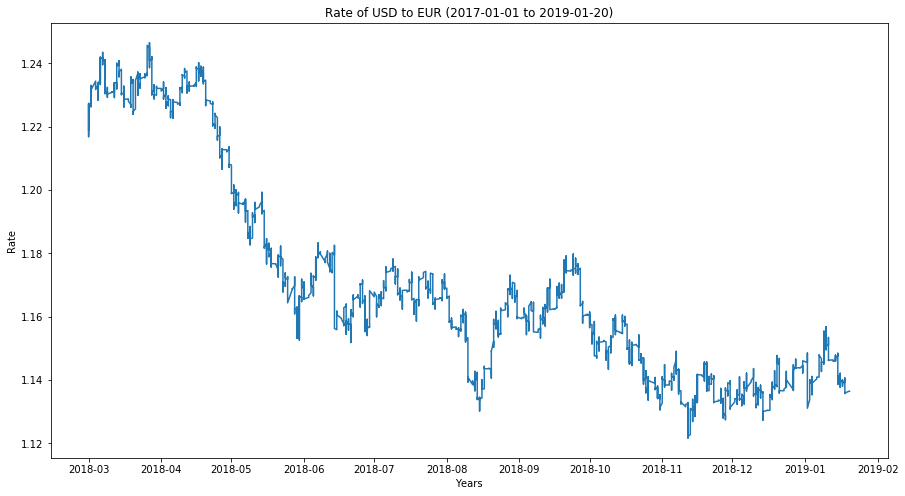

In [125]:
plt.plot(df_cut['Date'], df_cut['BidClose'])
plt.xlabel('Years')
plt.ylabel('Rate')
plt.title("Rate of USD to EUR (2017-01-01 to 2019-01-20)")

In [126]:
train_split = '2018-11-01'
usd_train = df_cut.loc[df_cut['Date'] <= train_split].copy()
usd_test = df_cut.loc[df_cut['Date'] > train_split].copy()

Text(0.5, 1.0, 'Splitted dateset')

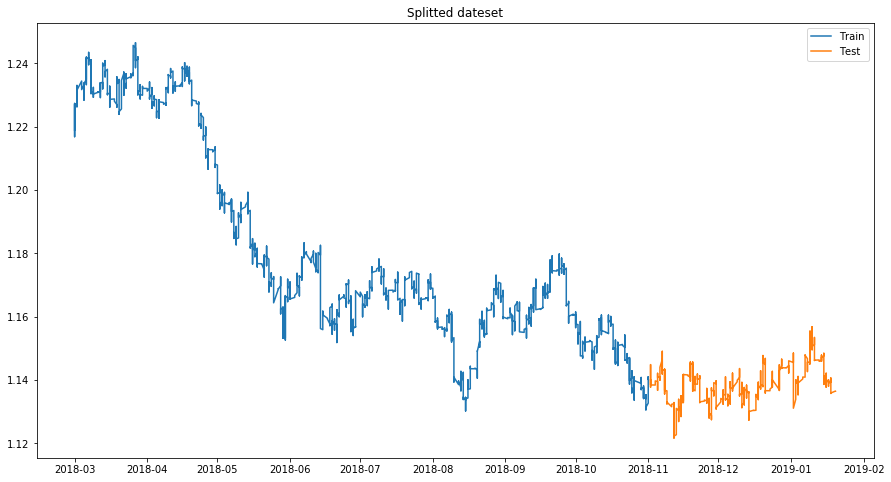

In [127]:
plt.plot(usd_train['Date'], usd_train['BidClose'], label='Train')
plt.plot(usd_test['Date'], usd_test['BidClose'], label='Test')
plt.legend(loc='best')
plt.title("Splitted dateset")

In [128]:
# borrow (with some tweaks) those functions from previous notebook

def create_features_dep(df, x_label='Date', y_label='BidClose'):
    return df[x_label].as_matrix().reshape((-1,1)), df[y_label].as_matrix()


def create_features(df, x_label='Date', y_label='BidClose'):
    # removed year feature, as we are working on 1.5 year sample
    df['hour'] = df[x_label].dt.hour
    df['quarter'] = df[x_label].dt.quarter
    df['month'] = df[x_label].dt.month
    df['dayofyear'] = df[x_label].dt.dayofyear
    df['dayofmonth'] = df[x_label].dt.day
    df['weekofyear'] = df[x_label].dt.weekofyear
    
    X = df[['hour','dayofyear','quarter','month', 'weekofyear', 'dayofmonth']]
    y = df[y_label]

    return X, y

In [178]:
X_train, y_train = create_features(usd_train)
X_test, y_test = create_features(usd_test)

In [185]:
reg = xgb.XGBClassifier(
#     colsample_bytree=0.8,
#     subsample=0.5,
#     learning_rate=0.15, 
#     max_depth=103, 
#     min_child_weight=1.5, 
#     n_estimators=6000,
#     reg_alpha=0.5, 
#     reg_lambda=0.5, 
#     gamma=0.55, 
#     nthread=-1
)

In [186]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False) # too much logs 

ValueError: y contains previously unseen labels: [1.12168, 1.12181, 1.12229, 1.12273, 1.1232600000000001, 1.12332, 1.12343, 1.1235, 1.1237700000000002, 1.12389, 1.1239700000000001, 1.12399, 1.12409, 1.1241, 1.1244299999999998, 1.1244399999999999, 1.12456, 1.12499, 1.12513, 1.12529, 1.12543, 1.12564, 1.1256899999999999, 1.12592, 1.1259299999999999, 1.12604, 1.12606, 1.1261299999999999, 1.1264299999999998, 1.1264399999999999, 1.12666, 1.1267399999999999, 1.1269, 1.12695, 1.12714, 1.12721, 1.12722, 1.12725, 1.12734, 1.12748, 1.12752, 1.1277700000000002, 1.1278, 1.12791, 1.12798, 1.128, 1.12804, 1.1281700000000001, 1.12825, 1.12832, 1.1284, 1.1284299999999998, 1.1284399999999999, 1.12847, 1.12849, 1.12869, 1.1287, 1.1287200000000002, 1.12873, 1.12878, 1.12879, 1.1288799999999999, 1.12895, 1.12899, 1.12901, 1.1291, 1.12911, 1.12914, 1.12915, 1.12921, 1.12923, 1.12925, 1.1293, 1.12931, 1.1293600000000001, 1.12945, 1.1294600000000001, 1.12958, 1.12962, 1.12965, 1.12966, 1.1297, 1.12973, 1.12983, 1.12984, 1.12986, 1.1299, 1.12994, 1.1299700000000001, 1.13001, 1.1300299999999999, 1.13029, 1.1303299999999998, 1.13037, 1.13044, 1.13046, 1.1306399999999999, 1.1307, 1.1307399999999999, 1.13076, 1.13078, 1.1308, 1.13085, 1.13086, 1.13087, 1.1309, 1.13095, 1.1309799999999999, 1.13104, 1.13107, 1.13109, 1.1311, 1.13115, 1.13116, 1.1312, 1.1312200000000001, 1.13127, 1.13143, 1.1314600000000001, 1.1314899999999999, 1.13157, 1.1316700000000002, 1.13172, 1.13174, 1.13176, 1.13181, 1.13186, 1.1318700000000002, 1.13189, 1.1319299999999999, 1.1320000000000001, 1.13201, 1.13206, 1.1320700000000001, 1.13214, 1.1322, 1.13224, 1.13227, 1.13229, 1.1323, 1.1323299999999998, 1.13236, 1.13239, 1.1324100000000001, 1.13244, 1.13245, 1.13248, 1.13258, 1.1326100000000001, 1.13263, 1.13267, 1.13269, 1.13273, 1.13276, 1.13277, 1.13278, 1.1328, 1.13284, 1.13286, 1.13287, 1.1328799999999999, 1.13289, 1.1329, 1.13291, 1.13293, 1.13294, 1.13296, 1.13297, 1.133, 1.13301, 1.13303, 1.13309, 1.13311, 1.13316, 1.13317, 1.1331799999999999, 1.1332, 1.13321, 1.1332200000000001, 1.13324, 1.13327, 1.1332799999999998, 1.13331, 1.13332, 1.13334, 1.13335, 1.1334, 1.13341, 1.13343, 1.13344, 1.13345, 1.1334600000000001, 1.1334799999999998, 1.13352, 1.13353, 1.13354, 1.1335600000000001, 1.13364, 1.13365, 1.13368, 1.1336899999999999, 1.13371, 1.13372, 1.13375, 1.13376, 1.1338, 1.1338700000000002, 1.13388, 1.1339, 1.13391, 1.13392, 1.1339299999999999, 1.1340299999999999, 1.1341, 1.1341299999999999, 1.13415, 1.13419, 1.1342, 1.13421, 1.1342299999999998, 1.1342700000000001, 1.13428, 1.13434, 1.13448, 1.13449, 1.13452, 1.1346, 1.13462, 1.13463, 1.1346399999999999, 1.13467, 1.13468, 1.13471, 1.13473, 1.1347399999999999, 1.13475, 1.1348, 1.13483, 1.13486, 1.13487, 1.13493, 1.13495, 1.13496, 1.1349799999999999, 1.13499, 1.135, 1.1350200000000001, 1.13503, 1.1351, 1.1351799999999999, 1.1352200000000001, 1.13524, 1.13526, 1.13529, 1.13532, 1.13533, 1.13534, 1.1353600000000001, 1.1353799999999998, 1.13539, 1.13541, 1.13544, 1.13545, 1.1354600000000001, 1.13547, 1.1354799999999998, 1.1354899999999999, 1.1355, 1.13558, 1.13561, 1.13562, 1.13572, 1.13576, 1.1357899999999999, 1.13585, 1.1358700000000002, 1.13589, 1.13591, 1.13592, 1.13596, 1.1359700000000001, 1.13598, 1.13599, 1.136, 1.13605, 1.13609, 1.1361, 1.13612, 1.13615, 1.13616, 1.1361700000000001, 1.13618, 1.1362, 1.13622, 1.1362700000000001, 1.13631, 1.1363299999999998, 1.13634, 1.13638, 1.1364, 1.1364100000000001, 1.1364299999999998, 1.13644, 1.13647, 1.13648, 1.1365, 1.13652, 1.1365299999999998, 1.13655, 1.1366, 1.1366100000000001, 1.13662, 1.13663, 1.1366399999999999, 1.13665, 1.13667, 1.13671, 1.13675, 1.13676, 1.1368, 1.13683, 1.13685, 1.13686, 1.13688, 1.1369, 1.1369200000000002, 1.13693, 1.13694, 1.13697, 1.13699, 1.13703, 1.1370799999999999, 1.13714, 1.13716, 1.1372799999999998, 1.1373, 1.13735, 1.13739, 1.13743, 1.1375, 1.13752, 1.13753, 1.13754, 1.13763, 1.13764, 1.1376600000000001, 1.13768, 1.1376899999999999, 1.13772, 1.13773, 1.13778, 1.1378, 1.1378700000000002, 1.13791, 1.1379299999999999, 1.13798, 1.13799, 1.138, 1.13801, 1.13802, 1.1380299999999999, 1.13804, 1.1381, 1.13811, 1.13812, 1.1381299999999999, 1.13816, 1.13818, 1.13824, 1.13828, 1.13831, 1.13834, 1.13838, 1.13839, 1.1384100000000001, 1.13842, 1.1384299999999998, 1.13846, 1.13847, 1.1385100000000001, 1.1385299999999998, 1.1385399999999999, 1.13858, 1.13859, 1.13862, 1.13868, 1.1387200000000002, 1.1387399999999999, 1.13875, 1.13876, 1.13877, 1.13878, 1.13881, 1.1388200000000002, 1.13883, 1.13884, 1.13886, 1.13889, 1.1389, 1.13894, 1.13895, 1.13899, 1.139, 1.13903, 1.13905, 1.13907, 1.13909, 1.1391, 1.1391200000000001, 1.13914, 1.13916, 1.13917, 1.1392, 1.1392200000000001, 1.13924, 1.13927, 1.13929, 1.1393, 1.13932, 1.13934, 1.13935, 1.13936, 1.1393799999999998, 1.13939, 1.13943, 1.13945, 1.13947, 1.1394799999999998, 1.13951, 1.13954, 1.13957, 1.13962, 1.13963, 1.13964, 1.1396700000000002, 1.13968, 1.1396899999999999, 1.13973, 1.13974, 1.13975, 1.13976, 1.13978, 1.1398, 1.13985, 1.1399, 1.13992, 1.13994, 1.1399700000000001, 1.14, 1.14002, 1.14005, 1.14006, 1.1400700000000001, 1.14008, 1.14011, 1.1401299999999999, 1.14014, 1.1402, 1.14021, 1.1402299999999999, 1.14024, 1.14026, 1.1402700000000001, 1.14028, 1.1403, 1.14031, 1.14032, 1.14034, 1.14037, 1.1404100000000001, 1.14042, 1.1404299999999998, 1.14044, 1.1405, 1.1405100000000001, 1.14052, 1.14057, 1.14062, 1.14066, 1.14067, 1.14069, 1.1407100000000001, 1.14073, 1.14077, 1.14078, 1.14083, 1.1408399999999999, 1.1409, 1.14093, 1.14094, 1.14095, 1.14096, 1.14097, 1.14099, 1.14101, 1.14105, 1.14106, 1.14111, 1.1411200000000001, 1.14114, 1.14115, 1.14123, 1.14126, 1.1412799999999999, 1.14129, 1.1413, 1.14133, 1.14134, 1.14136, 1.14137, 1.14141, 1.14142, 1.14143, 1.14151, 1.14154, 1.14155, 1.14163, 1.14165, 1.14168, 1.14172, 1.14173, 1.14174, 1.14175, 1.14176, 1.1417700000000002, 1.1417899999999999, 1.14184, 1.14189, 1.1419, 1.14193, 1.14198, 1.14199, 1.1420299999999999, 1.14209, 1.14211, 1.14214, 1.14216, 1.1421700000000001, 1.14219, 1.14221, 1.14222, 1.1422700000000001, 1.14237, 1.14238, 1.14239, 1.1424, 1.14248, 1.14249, 1.1425, 1.14252, 1.14256, 1.1426100000000001, 1.14263, 1.14265, 1.14267, 1.14269, 1.1427100000000001, 1.1427200000000002, 1.14276, 1.1428, 1.14281, 1.1428200000000002, 1.14288, 1.14289, 1.1429, 1.14291, 1.14293, 1.14294, 1.14304, 1.1430799999999999, 1.1431, 1.1431200000000001, 1.14314, 1.1432, 1.1432200000000001, 1.14323, 1.1432799999999999, 1.1433, 1.1433200000000001, 1.14334, 1.14335, 1.1433799999999998, 1.14344, 1.14345, 1.14347, 1.14349, 1.14352, 1.14354, 1.14355, 1.14361, 1.1436600000000001, 1.1437700000000002, 1.1437899999999999, 1.14381, 1.14382, 1.14383, 1.14384, 1.14385, 1.14386, 1.14388, 1.14389, 1.14391, 1.14393, 1.14395, 1.14398, 1.1440000000000001, 1.14401, 1.14402, 1.14405, 1.14406, 1.1441299999999999, 1.14416, 1.14419, 1.14425, 1.14426, 1.14429, 1.1443, 1.14431, 1.14438, 1.14442, 1.14447, 1.14448, 1.1445, 1.14452, 1.14454, 1.14455, 1.14457, 1.14463, 1.1447200000000002, 1.1447399999999999, 1.14478, 1.14479, 1.1448, 1.14481, 1.1448200000000002, 1.14486, 1.14488, 1.1449, 1.1449200000000002, 1.14497, 1.14501, 1.14505, 1.14506, 1.14507, 1.1450799999999999, 1.14509, 1.14511, 1.1451200000000001, 1.14513, 1.14515, 1.14517, 1.14519, 1.14521, 1.14523, 1.14533, 1.14535, 1.14539, 1.1454, 1.14541, 1.14544, 1.1455, 1.14552, 1.14553, 1.14554, 1.1455799999999998, 1.1455899999999999, 1.14563, 1.14567, 1.1456899999999999, 1.14573, 1.14582, 1.14583, 1.14584, 1.14591, 1.1459700000000002, 1.146, 1.1460299999999999, 1.1460700000000001, 1.14616, 1.1461700000000001, 1.14619, 1.14624, 1.1462700000000001, 1.1463299999999998, 1.1463700000000001, 1.1465100000000001, 1.14652, 1.1465299999999998, 1.14657, 1.14666, 1.1467, 1.14678, 1.14681, 1.14689, 1.1469, 1.14696, 1.14699, 1.1470200000000002, 1.1471200000000001, 1.14727, 1.14734, 1.14743, 1.14749, 1.14752, 1.1475600000000001, 1.1475899999999999, 1.14763, 1.14765, 1.14771, 1.1477600000000001, 1.14778, 1.1478, 1.14782, 1.1478700000000002, 1.1478899999999999, 1.1479, 1.14791, 1.14822, 1.14824, 1.14839, 1.1485100000000001, 1.14885, 1.1489200000000002, 1.149, 1.14906, 1.14955, 1.1497600000000001, 1.14994, 1.15056, 1.1507100000000001, 1.15099, 1.15163, 1.1519, 1.15216, 1.15224, 1.15235, 1.15238, 1.15244, 1.15245, 1.1525299999999998, 1.15259, 1.1526100000000001, 1.15272, 1.15278, 1.15279, 1.15285, 1.1531799999999999, 1.15343, 1.15353, 1.15406, 1.15419, 1.1542299999999999, 1.15473, 1.1551200000000001, 1.15531, 1.15595, 1.15683]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.8, missing=None, n_estimators=2000,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=7,
             reg_alpha=0.1, reg_lambda=0.3, scale_pos_weight=1, seed=None,
             silent=1, subsample=0.5, verbosity=1)

In [187]:
reg.fit(X_train, y_train) # too much logs 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

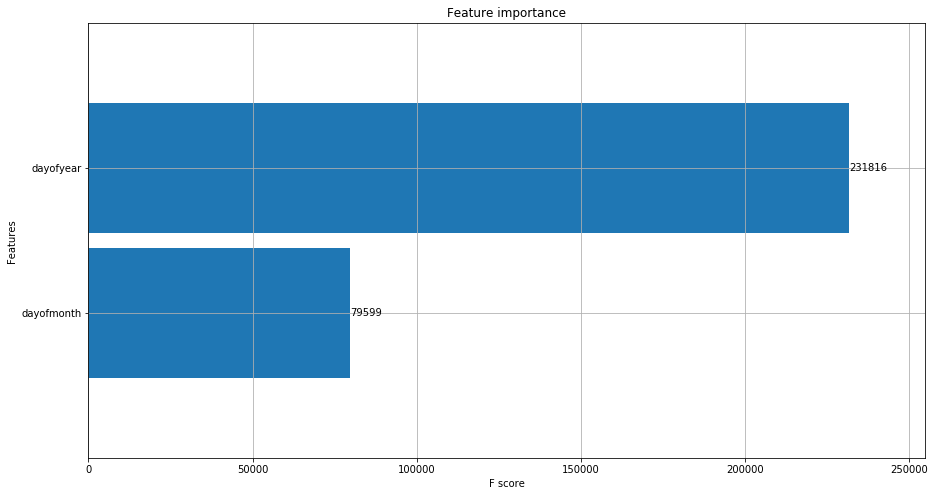

In [188]:
plot_importance(reg, height=0.9)

In [189]:
y_test_predicted = reg.predict(X_test)
usd_test['bid_prediction'] = y_test_predicted

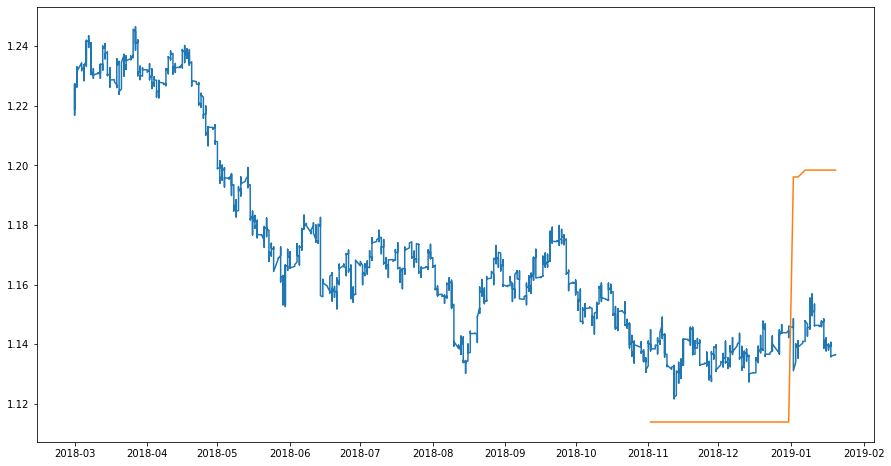

In [183]:
# plot predictions
plt.plot(df_cut['Date'], df_cut['BidClose'])
plt.plot(usd_test['Date'], usd_test['bid_prediction'])

In [184]:
RMSE = np.sqrt(mean_squared_error(y_test, y_test_predicted))

In [163]:
RMSE

0.01583302696945934